# Document Clustering and Topic Modeling

In this project, we use unsupervised learning models to cluster unlabeled documents into different groups, visualize the results and identify their latent topics/structures.

## Contents

<ul>
<li>[Part 1: Load Data](#Part-1:-Load-Data)
<li>[Part 2: Tokenizing and Stemming](#Part-2:-Tokenizing-and-Stemming)
<li>[Part 3: TF-IDF](#Part-3:-TF-IDF)
<li>[Part 4: K-means clustering](#Part-4:-K-means-clustering)
<li>[Part 5: Topic Modeling - Latent Dirichlet Allocation](#Part-5:-Topic-Modeling---Latent-Dirichlet-Allocation)
</ul>

# Part 1: Load Data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import nltk
import re
import os

from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import lda

Read data from files. In summary, we have 100 titles and 100 synoposes (combined from imdb and wiki).

In [2]:
#import three lists: titles and wikipedia synopses
titles = open('title_list.txt').read().split('\n')
titles = titles[:100] #ensures that only the first 100 are read in

#The wiki synopses and imdb synopses of each movie is seperated by the keywords "BREAKS HERE". 
#Each synoposes may consist of multiple paragraphs.
synopses_wiki = open('synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_imdb = open('synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

#Combine imdb and wiki to get full synoposes for the top 100 movies. 
synopses = []
for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)
    
#Because these synopses have already been ordered in popularity order, 
#we just need to generate a list of ordered numbers for future usage.
ranks = range(len(titles))

# Part 2: Tokenizing and Stemming

Load stopwords and stemmer function from NLTK library.
Stop words are words like "a", "the", or "in" which don't convey significant meaning.
Stemming is the process of breaking a word down into its root.

In [3]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')

print "We use " + str(len(stopwords)) + " stop-words from nltk library."
print stopwords[:10]

We use 179 stop-words from nltk library.
[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u"you're"]


In [4]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenization_and_stemming(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
#     tokens=[]
#     for sent in nltk.sent_tokenize(text):
#         for word in nltk.word_tokenize(sent):
#             if word not in stopwords:
#                 tokens.append(word);   
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenization(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [5]:
tokenization_and_stemming("she looked at her father's arm.")

[u'look', u'father', "'s", u'arm']

Use our defined functions to analyze (i.e. tokenize, stem) our synoposes.

In [6]:
docs_stemmed = []
docs_tokenized = []
for i in synopses:
    tokenized_and_stemmed_results = tokenization_and_stemming(i)
    docs_stemmed.extend(tokenized_and_stemmed_results)
    
    tokenized_results = tokenization(i)
    docs_tokenized.extend(tokenized_results)

Create a mapping from stemmed words to original tokenized words for result interpretation.

In [7]:
vocab_frame_dict = {docs_stemmed[x]:docs_tokenized[x] for x in range(len(docs_stemmed))}
print vocab_frame_dict['angel']

angeles


# Part 3: TF-IDF

In [8]:
#define vectorizer parameters
tfidf_model = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenization_and_stemming, ngram_range=(1,1))

tfidf_matrix = tfidf_model.fit_transform(synopses) #fit the vectorizer to synopses

print "In total, there are " + str(tfidf_matrix.shape[0]) + \
      " synoposes and " + str(tfidf_matrix.shape[1]) + " terms."

In total, there are 100 synoposes and 538 terms.


In [9]:
tfidf_model.get_params()

{'analyzer': u'word',
 'binary': False,
 'decode_error': u'strict',
 'dtype': numpy.int64,
 'encoding': u'utf-8',
 'input': u'content',
 'lowercase': True,
 'max_df': 0.8,
 'max_features': 200000,
 'min_df': 0.2,
 'ngram_range': (1, 1),
 'norm': u'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': 'english',
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': u'(?u)\\b\\w\\w+\\b',
 'tokenizer': <function __main__.tokenization_and_stemming>,
 'use_idf': True,
 'vocabulary': None}

Save the terms identified by TF-IDF.

In [10]:
tf_selected_words = tfidf_model.get_feature_names()

### Calculate Document Similarity

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
cos_matrix = cosine_similarity(tfidf_matrix)
print cos_matrix

[[1.         0.1996283  0.23342595 ... 0.3581728  0.3277855  0.17714484]
 [0.1996283  1.         0.26626879 ... 0.26910321 0.22856581 0.10870124]
 [0.23342595 0.26626879 1.         ... 0.27738654 0.24669308 0.12805055]
 ...
 [0.3581728  0.26910321 0.27738654 ... 1.         0.55040973 0.08151334]
 [0.3277855  0.22856581 0.24669308 ... 0.55040973 1.         0.13005234]
 [0.17714484 0.10870124 0.12805055 ... 0.08151334 0.13005234 1.        ]]


# Part 4: K-means clustering

In [12]:
from sklearn.cluster import KMeans

num_clusters = 3
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

## 4.1. Analyze K-means Result

In [13]:
# create DataFrame films from all of the input files.
films = { 'title': titles, 'rank': ranks, 'cluster': clusters}
frame = pd.DataFrame(films, columns = ['rank', 'title', 'cluster'])
frame.head(10)

,rank,title,cluster
0,0,The Godfather,1
1,1,The Shawshank Redemption,2
2,2,Schindler's List,2
3,3,Raging Bull,1
4,4,Casablanca,2
5,5,One Flew Over the Cuckoo's Nest,2
6,6,Gone with the Wind,1
7,7,Citizen Kane,1
8,8,The Wizard of Oz,0
9,9,Titanic,0


In [14]:
print "Number of films included in each cluster:"
frame['cluster'].value_counts().to_frame()

Number of films included in each cluster:


,cluster
0,38
1,35
2,27


In [15]:
grouped = frame['rank'].groupby(frame['cluster'])
print "Average rank (1 to 100) per cluster:"
grouped.mean().to_frame()

Average rank (1 to 100) per cluster:


,rank
cluster,
0,53.315789
1,52.457143
2,40.296296


In [16]:

print "<Document clustering result by K-means>"

# km.cluster_centers_ denotes the importances of each items in centroid.
# need to sort it in descending order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print "Cluster " + str(i) + " words:" ,
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]: # get the top 6 words of each cluster
        Cluster_keywords_summary[i].append(vocab_frame_dict[tf_selected_words[ind]])
        print vocab_frame_dict[tf_selected_words[ind]] + ", ",
    print 

    cluster_movies = frame.loc[frame.cluster == i, 'title'].values.tolist()
    print "Cluster " + str(i) + " titles (" + str(len(cluster_movies)) + " movies): " 
    print ", ".join(cluster_movies), '\n'

<Document clustering result by K-means>
Cluster 0 words: car,  police,  friend,  apartment,  love,  meet, 
Cluster 0 titles (38 movies): 
The Wizard of Oz, Titanic, Psycho, Sunset Blvd., Vertigo, On the Waterfront, Forrest Gump, West Side Story, E.T. the Extra-Terrestrial, 2001: A Space Odyssey, The Silence of the Lambs, Chinatown, Singin' in the Rain, Some Like It Hot, 12 Angry Men, Gandhi, Rocky, Ben-Hur, The Apartment, The Exorcist, The French Connection, Annie Hall, Good Will Hunting, Tootsie, Fargo, The Green Mile, Close Encounters of the Third Kind, Nashville, American Graffiti, Pulp Fiction, The Maltese Falcon, A Clockwork Orange, Taxi Driver, Wuthering Heights, Double Indemnity, Rear Window, The Third Man, North by Northwest 

Cluster 1 words: father,  family,  george,  marries,  new,  brother, 
Cluster 1 titles (35 movies): 
The Godfather, Raging Bull, Gone with the Wind, Citizen Kane, The Godfather: Part II, The Sound of Music, It's a Wonderful Life, Amadeus, A Streetcar Name

## 4.2. Plot K-means Result

In [17]:
pca = decomposition.PCA(n_components=6)
tfidf_matrix_np=tfidf_matrix.toarray()
pca.fit(tfidf_matrix_np)
X = pca.transform(tfidf_matrix_np)

xs, ys = X[:, 0], X[:, 1]

#set up colors per clusters using a dict
cluster_colors = {0: 'g', 1: 'b', 2: 'r', 3: 'y', 4:'k',5:'m'}
#set up cluster names using a dict
cluster_names = {}
for i in range(num_clusters):
    cluster_names[i] = ", ".join(Cluster_keywords_summary[i])

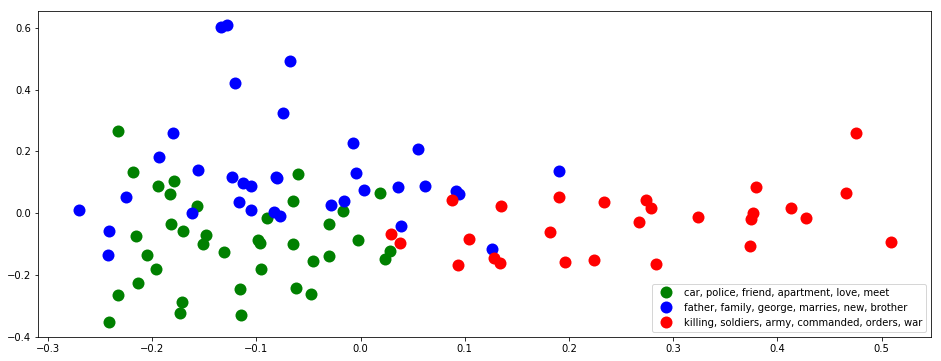

In [18]:
%matplotlib inline 

#create data frame with PCA cluster results
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 
groups = df.groupby(clusters)

# set up plot
fig, ax = plt.subplots(figsize=(16, 6))
#Set color for each cluster/group
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')

ax.legend(numpoints=1,loc=4)  #show legend with only 1 point, position is right bottom.

plt.show() #show the plot

# Part 5: Topic Modeling - Latent Dirichlet Allocation

In [26]:
#Now we use synopses to build a 100*551 matrix (terms)
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=3, learning_method = 'online')

tfidf_matrix_lda = (tfidf_matrix * 100)
tfidf_matrix_lda = tfidf_matrix_lda.astype(int)

In [27]:
lda.fit(tfidf_matrix_lda)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=3, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

<li> "model.topic_word_" saves the importance of tf_selected_words in LDA model, i.e. words similarity matrix
<li> The shape of "model.topic_word_" is (n_topics,num_of_selected_words)
<li> "model.doc_topic_" saves the document topic results, i.e. document topic matrix.
<li> The shape of "model.doc_topic_" is (num_of_documents, n_topics)

In [28]:
topic_word = lda.components_
print topic_word.shape

(3, 538)


In [29]:
n_top_words = 7
topic_keywords_list = []
for i, topic_dist in enumerate(topic_word):
    #Here we select top(n_top_words-1)
    lda_topic_words = np.array(tf_selected_words)[np.argsort(topic_dist)][:-n_top_words:-1] 
    for j in range(len(lda_topic_words)):
        lda_topic_words[j] = vocab_frame_dict[lda_topic_words[j]]
    topic_keywords_list.append(lda_topic_words.tolist())

In [30]:
topic_keywords_list

[[u'car', u'police', u'father', u'drives', u'meet', u'killing'],
 [u'killing', u'army', u'soldiers', u'war', u'men', u'captain'],
 [u'george', u'love', u'apartment', u'woman', u'family', u'marries']]

In [31]:
doc_topic = lda.transform(tfidf_matrix_lda)
print doc_topic.shape

(100, 3)


In [32]:
topic_doc_dict = {}
print "<Document clustering result by LDA>"
for i in range(len(doc_topic)):
    topicID = doc_topic[i].argmax()
    if topicID not in topic_doc_dict:
        topic_doc_dict[topicID] = [titles[i]]
    else:
        topic_doc_dict[topicID].append(titles[i])
for i in topic_doc_dict:
    print "Cluster " + str(i) + " words: " + ", ".join(topic_keywords_list[i])
    print "Cluster " + str(i) + " titles (" + str(len(topic_doc_dict[i])) + " movies): " 
    print ', '.join(topic_doc_dict[i])
    print

<Document clustering result by LDA>
Cluster 0 words: car, police, father, drives, meet, killing
Cluster 0 titles (33 movies): 
The Godfather, One Flew Over the Cuckoo's Nest, The Wizard of Oz, Titanic, Psycho, Sunset Blvd., Vertigo, On the Waterfront, West Side Story, E.T. the Extra-Terrestrial, 2001: A Space Odyssey, Chinatown, Singin' in the Rain, Some Like It Hot, 12 Angry Men, The Best Years of Our Lives, The Exorcist, The French Connection, City Lights, It Happened One Night, Rain Man, Good Will Hunting, Fargo, Close Encounters of the Third Kind, The Graduate, American Graffiti, Pulp Fiction, The Maltese Falcon, Taxi Driver, Double Indemnity, Rebel Without a Cause, The Third Man, North by Northwest

Cluster 1 words: killing, army, soldiers, war, men, captain
Cluster 1 titles (34 movies): 
Schindler's List, Casablanca, Lawrence of Arabia, The Sound of Music, Star Wars, The Bridge on the River Kwai, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now

We got a similar set of three clusters/topics as those we got with KMeans, but the topic keywords are different.

